# 普通最小二乘法回归
---
最标准的线性模型是“普通最小二乘回归”，通常简称为“线性回归”。 它没有对coef_施加任何额外限制，因此当特征数量很大时，它会变得行为异常，并且模型会过拟合。
$$\underset{\theta}{min} {|| X\theta - y||_2}^2$$
通过回归方程求导得到的最佳系数$\hat\theta = (X^TX)^{-1}X^Ty$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4, suppress=True, threshold=16)
%matplotlib inline

**make_regression**
```
Generate a random regression problem.
    n_samples=100,
    n_features=100,
    n_informative=10,
    n_targets=1,
    bias=0.0,
    effective_rank=None,
    tail_strength=0.5,
    noise=0.0,
    shuffle=True,
    coef=False,
    random_state=None,
```
```
Returns
-------
X : array of shape [n_samples, n_features]
    The input samples.

y : array of shape [n_samples] or [n_samples, n_targets]
    The output values.

coef : array of shape [n_features] or [n_features, n_targets], optional
    The coefficient of the underlying linear model. It is returned only if
    coef is True.
```

In [8]:
# 只有10个是有用的特征 , 添加了噪声
X, y, true_coef = make_regression(n_samples=200, n_features=30, n_informative=10, noise=100, coef=True, random_state=5)  
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, train_size=140, test_size=60)
print(X_train.shape)
print(y_train.shape)

(140, 30)
(140,)


In [9]:
true_coef

array([ 0.    ,  0.    ,  2.1223, ...,  0.    , 80.8129,  0.    ])

**R2 score, 用来计算[可决系数](https://baike.baidu.com/item/%E5%8F%AF%E5%86%B3%E7%B3%BB%E6%95%B0)(the coefficient of determination)**
$$R^2(y, \hat y) = 1 - \frac {\sum_{i=1}^{n\_sample}(y_i - \hat y_i)^2}{\sum_{i=1}^{n\_sample}(y_i - \bar y)^2}$$
其中$y_i$表示第i个样本的真实值, $\hat y_i$ 为预测值,   
$\bar y = \frac 1 {n\_sample}\sum_{i=1}^{n\_sample} y_i$为实际值的均值
R2 score的值为1.0时最佳, 也可能为负数

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("R^2 on training set: %f" % lr.score(X_train, y_train))
print("R^2 on test set: %f" % lr.score(X_test, y_test))

R^2 on training set: 0.752491
R^2 on test set: 0.722270


In [11]:
from sklearn.metrics import r2_score
# 整体集合的R2 score
r2_score(np.dot(X, true_coef), y)

0.5985284495875146

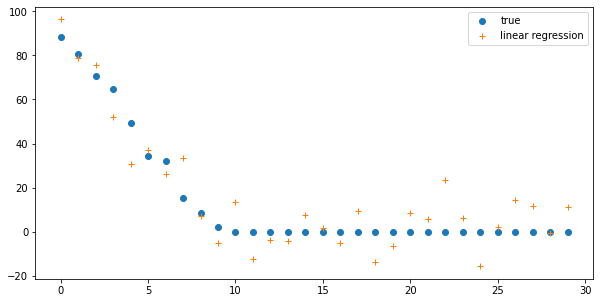

In [12]:
plt.figure(figsize=(10, 5))
# 系数从大到小排序 画图比较
coefficient_sorting = np.argsort(true_coef)[::-1]
plt.plot(true_coef[coefficient_sorting], "o", label="true")
plt.plot(lr.coef_[coefficient_sorting], "+", label="linear regression")

plt.legend()

**learning curve 学习曲线**
---
A learning curve shows the validation and training score of an estimator for varying numbers of training samples.

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(.1, 1, 5), cv=5)
train_sizes

array([ 16,  52,  88, 124, 160])

In [8]:
learning_curve?

Signature:
learning_curve(
    estimator,
    X,
    y,
    groups=None,
    train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=None,
    pre_dispatch='all',
    verbose=0,
    shuffle=False,
    random_state=None,
    error_score=nan,
    return_times=False,
)
Docstring:
Learning curve.

Determines cross-validated training and test scores for different training
set sizes.

A cross-validation generator splits the whole dataset k times in training
and test data. Subsets of the training set with varying sizes will be used
to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over
all k runs for each training subset size.

Read more in the :ref:`User Guide <learning_curve>`.

Parameters
----------
estimator : object type that implements the "fit" and "predict" methods
    An object of that type which is cloned for each

In [14]:
train_scores  # (n_ticks, n_cv_folds)

array([[1.    , 1.    , 1.    , 1.    , 1.    ],
       [0.8361, 0.8313, 0.8395, 0.8395, 0.8395],
       [0.8266, 0.7631, 0.7211, 0.7461, 0.7461],
       [0.8401, 0.7952, 0.7754, 0.7855, 0.7735],
       [0.8028, 0.7629, 0.7478, 0.7579, 0.7798]])

In [16]:
valid_scores

array([[-0.4851,  0.2807,  0.2403, -0.1845,  0.4229],
       [ 0.0926,  0.2826,  0.4763, -0.0515,  0.2072],
       [ 0.1387,  0.6938,  0.7296,  0.5487,  0.5216],
       [ 0.17  ,  0.6873,  0.7396,  0.6146,  0.6083],
       [ 0.288 ,  0.7235,  0.749 ,  0.6684,  0.6191]])

In [13]:
def plot_learning_curve(est, X, y):
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        LinearRegression(), X, y, train_sizes=np.linspace(.1, 1, 20), cv=5)
    estimator_name = est.__class__.__name__
    # 训练集的 训练集大小-socre 分数 曲线
    line = plt.plot(train_sizes, train_scores.mean(axis=1), '--', label=f"train scores {estimator_name}")
    plt.plot(train_sizes, test_scores.mean(axis=1), '-', label=f"test scores {estimator_name}")
    plt.xlabel("Training set size")
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)

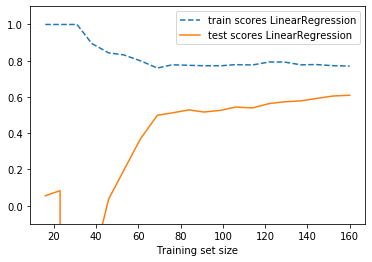

In [14]:
plot_learning_curve(LinearRegression(), X, y)
# 不同训练集大小 训练出来的 结果

**普通最小二乘法的复杂度**

该方法使用 X 的奇异值分解来计算最小二乘解。如果 X 是一个形状为 (n_samples, n_features)的矩阵，设$$n_{samples} \geq n_{features}$$, 则该方法的复杂度为$$O(n_{samples} n_{fearures}^2)$$

# 岭回归（L2 惩罚）
---
岭估计器是普通LinearRegression的简单正则化（称为 l2 惩罚）。 特别是，它具有的优点是，在计算上不比普通的最小二乘估计更昂贵。
$$\underset {\theta}{min} ||X\theta - y||_2^2 + \alpha ||\theta||_2^2$$
其中， $\alpha \geq 0$ 是控制系数收缩量的复杂性参数： $\alpha$ 的值越大，收缩量越大，模型对共线性的鲁棒性也更强。

最优的$\hat \theta = (X^TX+\alpha I)^{-1}X^Ty$, 它是一个关于$\alpha$的函数.  
**岭回归的复杂度**
这种方法与 `普通最小二乘法` 的复杂度是相同的.

让我们加载一个不满秩（low effective rank）数据集来比较岭回归和线性回归。秩是矩阵线性无关组的数量，满秩是指一个$m \times n$矩阵中行向量或列向量中现行无关组的数量等于$min(m,n)$。

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [18]:
# 建一个有3个自变量的数据集，但是其秩为2，因此3个自变量中有两个自变量存在相关性
X, y = make_regression(n_samples=2000, n_features=3, effective_rank=2, noise=10)
X

array([[-0.02  , -0.0037,  0.0263],
       [-0.0103,  0.0113, -0.0201],
       [-0.0202, -0.0107, -0.0076],
       ...,
       [-0.0085, -0.0218, -0.0011],
       [ 0.0159,  0.0081, -0.0321],
       [-0.0031, -0.0117, -0.0085]])

In [19]:
def plot_regression(lr, X, y):
    n_sample, n_feature = X.shape
    n_bootstraps = 1000 # 1000次
    coefs = np.zeros((n_bootstraps, n_feature))
    scores = np.zeros((n_bootstraps, 2))
    
    # 重复 n_bootstraps
    for i in range(n_bootstraps):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
        lr.fit(X_train, y_train)
        scores[i] = (lr.score(X_train, y_train), lr.score(X_test, y_test))
        coefs[i] = lr.coef_
    f, axes = plt.subplots(nrows=n_feature, sharex=True, sharey=True, figsize=(10, 8))
    # 查看这n_bootstraps次 3个特征系数的分布
    for i, ax in enumerate(axes):
        # 频率分布直方图
        ax.hist(coefs[:, i], alpha=.5)
        ax.set_title("Coef {}".format(i))
    plt.show()
    return coefs, scores

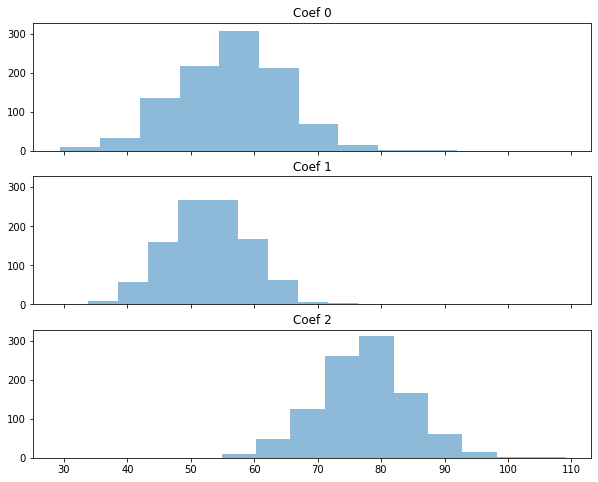

In [20]:
# 普通的线性回归
coefs_lr, scores_lr = plot_regression(LinearRegression(), X, y)

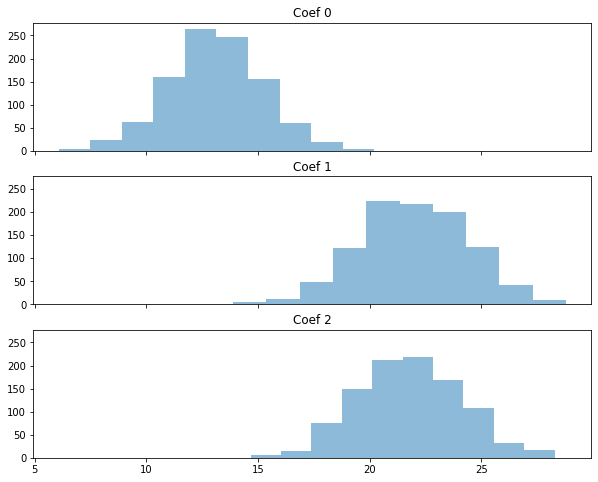

In [21]:
# 岭回归
coefs_ridge, scores_ridge = plot_regression(Ridge(), X, y)  # 正则化系数 alpha 默认1.0

显然, 岭回归的系数更接近0

In [15]:
np.mean(coefs_ridge - coefs_lr, axis=0)

array([-39.922 , -16.9649, -18.7397])

从均值上看，线性回归比岭回归的系数要大很多。均值显示的差异其实是线性回归的系数隐含的偏差

In [22]:
coefs_lr.var(0)

array([67.5145, 40.129 , 49.8632])

In [23]:
coefs_ridge.var(0)

array([4.4512, 5.6909, 5.1915])

In [24]:
scores_lr

array([[0.0354, 0.0317],
       [0.0326, 0.042 ],
       [0.0339, 0.0288],
       ...,
       [0.0328, 0.0367],
       [0.0325, 0.0415],
       [0.0347, 0.0342]])

In [25]:
scores_lr.mean(0), scores_ridge.mean(0)

(array([0.0355, 0.0287]), array([0.019, 0.015]))

岭回归的系数方差也会小很多。这就是机器学习里著名的偏差-方差均衡(Bias-Variance Trade-off)

## 优化岭回归参数 
---
用OLS（普通最小二乘法）做回归也许可以显示两个变量之间的某些关系；但是，当alpha参数正则化之后，那些关系就会消失.

在linear_models模块中，有一个对象叫RidgeCV，表示**岭回归交叉检验**（ridge cross-validation）。这个交叉检验类似于**留一交叉验证法**（leave-one-out cross-validation，LOOCV）

指定cv属性的值将触发(通过GridSearchCV的)交叉验证。例如，cv=10将触发10折的交叉验证，而不是广义交叉验证(GCV)。

In [23]:
RidgeCV?

Init signature:
RidgeCV(
    alphas=(0.1, 1.0, 10.0),
    fit_intercept=True,
    normalize=False,
    scoring=None,
    cv=None,
    gcv_mode=None,
    store_cv_values=False,
)
Docstring:     
Ridge regression with built-in cross-validation.

See glossary entry for :term:`cross-validation estimator`.

By default, it performs Generalized Cross-Validation, which is a form of
efficient Leave-One-Out cross-validation.

Read more in the :ref:`User Guide <ridge_regression>`.

Parameters
----------
alphas : ndarray of shape (n_alphas,), default=(0.1, 1.0, 10.0)
    Array of alpha values to try.
    Regularization strength; must be a positive float. Regularization
    improves the conditioning of the problem and reduces the variance of
    the estimates. Larger values specify stronger regularization.
    Alpha corresponds to ``C^-1`` in other linear models such as
    LogisticRegression or LinearSVC.
    If using generalized cross-validation, alphas must be positive.

fit_intercept : bool, de

In [26]:
from sklearn.linear_model import RidgeCV

X, y = make_regression(n_samples=100, n_features=2, effective_rank=1, noise=10, random_state=12345)
rcv = RidgeCV(alphas=np.logspace(-5, 5, 11))
rcv.fit(X, y)

RidgeCV(alphas=array([     0.    ,      0.0001,      0.001 ,      0.01  ,      0.1   ,
            1.    ,     10.    ,    100.    ,   1000.    ,  10000.    ,
       100000.    ]))

In [27]:
# 拟合模型之后，alpha参数就是最优正则化系数：
rcv.alpha_

0.01

In [28]:
# 查看0.1附近更优的alpha值
rcv = RidgeCV(alphas=np.linspace(.05, .2, 16))
rcv.fit(X, y)
rcv.alpha_

0.05

In [29]:
alpha_list = np.linspace(0.001, 1, 1000)
rcv = RidgeCV(alphas=alpha_list, store_cv_values=True)  # 保存交叉检验的数据
rcv.fit(X, y)

RidgeCV(alphas=array([0.001, 0.002, 0.003, ..., 0.998, 0.999, 1.   ]),
        store_cv_values=True)

In [30]:
rcv.cv_values_.shape  # 100次交叉验证  1000个不同alpha 的均方根误差

(100, 1000)

In [31]:
min_alpha_idx = rcv.cv_values_.mean(0).argmin()
min_alpha_idx

35

In [32]:
alpha_list[min_alpha_idx]

0.036000000000000004

In [33]:
rcv.alpha_

0.036000000000000004

In [40]:
def plt_ridgecv(alpha_list, X, y):
    rcv = RidgeCV(alphas=alpha_list, store_cv_values=True)  # 保存交叉检验的数据
    rcv.fit(X, y)
    min_alpha_idx = rcv.cv_values_.mean(0).argmin()
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(r"Various values of $\alpha$")
    min_alpha = alpha_list[min_alpha_idx]
    xy = (min_alpha, rcv.cv_values_.mean(axis=0)[min_alpha_idx])
    xytext = (xy[0] + .01, xy[1] + .1)
    
    ax.annotate(r'Chosen $\alpha$={:.3f}'.format(min_alpha), xy=xy, xytext=xytext,
            arrowprops=dict(facecolor='black', shrink=0, width=0)
            )
    ax.plot(alpha_list, rcv.cv_values_.mean(axis=0))

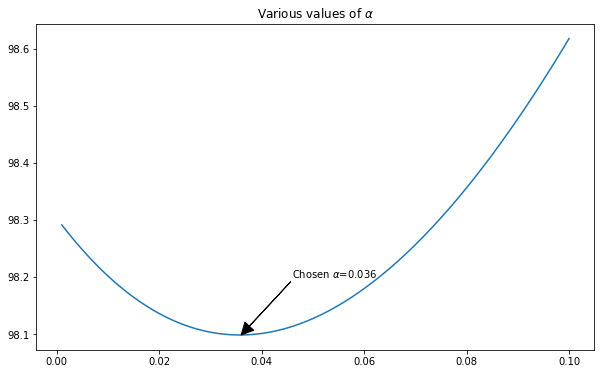

In [41]:
plt_ridgecv(np.linspace(0.001, 0.1, 100), X, y)

In [43]:
from sklearn.metrics import make_scorer
# 使用自定义的函数(偏差的绝对值的均值)   作为评分函数
def mean_absoult_error(y, y_pred):
    return np.abs(y - y_pred).mean()
MAE = make_scorer(mean_absoult_error, greater_is_better=False)  # 
rcv = RidgeCV(alphas=np.linspace(0.01, 0.1, 100), store_cv_values=True, scoring=MAE)
rcv.fit(X, y)

RidgeCV(alphas=array([0.01  , 0.0109, 0.0118, ..., 0.0982, 0.0991, 0.1   ]),
        scoring=make_scorer(mean_absoult_error, greater_is_better=False),
        store_cv_values=True)

In [44]:
rcv.alpha_

0.01

In [45]:
rcv.cv_values_.mean(0).argmin()

0

# LASSO 正则化
---
LASSO（ least absolute shrinkage and selection operator，最小绝对值收缩和选择算子）方法与岭回归和LARS（least angle regression，最小角回归）很类似。与岭回归类似，它也是通过增加惩罚函数来判断、消除特征间的共线性。与LARS相似的是它也可以用作参数选择，通常得出一个相关系数的稀疏向量。

`Lasso` 类的实现使用了 coordinate descent （坐标下降算法）来拟合系数

其最小化的目标函数是
$$\underset {\theta} {min} ||X\theta-y||^2 + \alpha||\theta||_1$$
最小化残差平方和的另一种表达方式是：

$$ RSS(\theta),其中 {\begin{Vmatrix} \theta \end{Vmatrix}}_1 \lt \theta $$
这个约束会让数据稀疏。LASSO回归的约束创建了围绕原点的超立方体（相关系数是轴），也就意味着大多数点都在各个顶点上，那里相关系数为0。而岭回归创建的是超平面，因为其约束是L2范数，少一个约束，但是即使有限制相关系数也不会变成0。


In [46]:
# 500个特征中只有5个是有用的
X, y = make_regression(n_samples=200, n_features=500, n_informative=5, noise=5, random_state=12345)

In [47]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X, y)  # 默认alpha 也是1. 设置为0时就变成普通线性回归

Lasso()

In [48]:
np.sum(lasso.coef_ != 0)   # 其余系数都是0

7

In [49]:
# 如果使用线性回归, 就有500个系数
lasso_0 = Lasso(alpha=0)
lasso_0.fit(X, y)
np.sum(lasso_0.coef_ != 0) 

500

**LASSO交叉验证**  
操作上与岭回归的交叉验证差不多

In [50]:
from sklearn.linear_model import LassoCV
alpha_list = np.logspace(-5, 5, 11)
lasso_cv = LassoCV(alphas=alpha_list)
lasso_cv.fit(X, y)

LassoCV(alphas=array([     0.    ,      0.0001,      0.001 ,      0.01  ,      0.1   ,
            1.    ,     10.    ,    100.    ,   1000.    ,  10000.    ,
       100000.    ]))

In [51]:
lasso_cv.alpha_  # 通过交叉验证得到最优的正则化系数

1.0

In [52]:
np.sum(lasso_cv.coef_ != 0)  # 交叉验证之后的非零系数数量

7

**LASSO特征选择**
---
LASSO通常用来为其他方法所特征选择([L1-based feature selection](https://github.com/apachecn/sklearn-doc-zh/blob/master/docs/0.21.3/14.md#11341-%E5%9F%BA%E4%BA%8E-l1-%E7%9A%84%E7%89%B9%E5%BE%81%E9%80%89%E5%8F%96))。例如，你可能会用LASSO回归获取适当的特征变量，然后在其他算法中使用。

要获取想要的特征，需要创建一个非零相关系数的列向量，然后再其他算法拟合

In [53]:
mask = lasso_cv.coef_ != 0
X_new = X[:, mask]
X_new.shape

(200, 7)

# LARS (Least Angle Regression)
---
最小角回归 （LARS） 是对高维数据的回归算法， 由 Bradley Efron, Trevor Hastie, Iain Johnstone 和 Robert Tibshirani 开发完成。 LARS 和逐步回归很像。在每一步，它都寻找与响应最有关联的预测。当有很多预测有相同的关联时，它并不会继续利用相同的预测，而是在这些预测中找出应该等角的方向。

LARS的优点:

- 当 p(n_feature) >> n(n_sample)，该算法数值运算上非常有效。(例如当维度的数目远超点的个数)
- 它在计算上和前向选择一样快，和普通最小二乘法有相同的运算复杂度。
- 它产生了一个完整的分段线性的解决路径，在交叉验证或者其他相似的微调模型的方法上非常有用。
- 如果两个变量对响应几乎有相等的联系，则它们的系数应该有相似的增长率。因此这个算法和我们直觉 上的判断一样，而且还更加稳定。
- 它很容易修改并为其他估算器生成解，比如Lasso。

LARS 的缺点:
- 因为 LARS 是建立在循环拟合剩余变量上的，所以它对噪声非常敏感。

[算法的具体描述](https://blog.csdn.net/u014664226/article/details/52240272/)

In [54]:
X, y = make_regression(n_samples=200, n_features=500, 
                       n_informative=10, noise=2, random_state=12345)

由于我们用了10个信息特征，因此我们还要为LARS设置10个非0的相关系数。我们事先可能不知道信息特征的准确数量，但是出于试验的目的是可行的：

In [64]:
from sklearn.linear_model import Lars

lars = Lars(n_nonzero_coefs=10)
train_n = 100
lars.fit(X[:train_n], y[:train_n])

Lars(n_nonzero_coefs=10)

In [65]:
np.sum(lars.coef_ != 0)

10

In [66]:

lars_12 = Lars(n_nonzero_coefs=12)  # 10左右估计一个值
lars_12.fit(X[:train_n], y[:train_n])

Lars(n_nonzero_coefs=12)

In [67]:
lars_500 = Lars()  # 默认所有系数非零
lars_500.fit(X[:train_n], y[:train_n])

Lars()

In [68]:
np.power(y[:train_n]-lars_12.predict(X[:train_n]), 2).mean()  # 12 训练集

39.15647832655108

In [69]:
np.power(y[:train_n]-lars_500.predict(X[:train_n]), 2).mean()  # 500 训练集

32.40942355263764

In [70]:
np.power(y[train_n:]-lars.predict(X[train_n:]), 2).mean()

3611.519726090217

In [71]:
np.power(y[train_n:]-lars_12.predict(X[train_n:]), 2).mean()  # 12 测试集

61.26807154043698

In [72]:
np.power(y[train_n:]-lars_500.predict(X[train_n:]), 2).mean()  # 500 测试集

1.934359127761053e+29

测试集的误差明显高很多。高维数据集问题就在于此；通常面对大量的特征时，想找出一个对训练集拟合很好的模型并不难，但是拟合过度却是更大的问题

# 贝叶斯回归
---
贝叶斯回归可以用于在预估阶段的参数正则化: 正则化参数的选择不是通过人为的选择，而是通过手动调节数据值来实现。
上述过程可以通过引入 无信息先验 到模型中的超参数来完成。 在`岭回归`中使用的 $\ell_{2}$ 正则项相当于在 w 为高斯先验条件，且此先验的精确度为 $\lambda^{-1}$ 时，求最大后验估计。在这里，我们没有手工调参数 lambda ，而是让他作为一个变量，通过数据中估计得到。

为了得到一个全概率模型，输出y也被认为是关于 X w 的高斯分布。
$$p(y|X,w,\alpha) = \mathcal{N}(y|X w,\alpha)$$

**贝叶斯岭回归**

`BayesianRidge `利用概率模型估算了上述的回归问题，其先验参数$\theta$是由以下球面高斯公式得出的
$$p(\theta|\lambda) =\mathcal{N}(\theta|0,\lambda^{-1}{I_{p}})$$

> $I_{p}$为指示函数

先验参数 $\alpha $和 $\lambda$ 一般是服从[Gamma](https://blog.csdn.net/chenshulong/article/details/79027103)分布 ，这个分布与高斯成共轭先验关系。 得到的模型一般称为`贝叶斯岭回归`，并且这个与传统的 Ridge 非常相似。

In [75]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=2, noise=20)

In [76]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge()
br.fit(X, y)

BayesianRidge()

有两组相关系数，分别是alpha_1 / alpha_2和lambda_1 / lambda_2。其中，alpha_*是先验概率分布的$\alpha$超参数，lambda_*是先验概率分布的$\lambda$超参数。

In [77]:
br.coef_

array([-0.4191, -0.3248, -0.3828, -0.9381, 45.7571,  0.2577,  0.4105,
        0.6797,  3.6498, -0.8944])

In [78]:
# 我们来调整超参数，注意观察相关系数的变化
br_alphas = BayesianRidge(alpha_1=10, lambda_1=10)
br_alphas.fit(X, y)
br_alphas.coef_

array([-0.4163, -0.3219, -0.3849, -0.9332, 45.5837,  0.2572,  0.4111,
        0.6688,  3.6309, -0.8883])

# 弹性网络

弹性网络 是一种使用 L1， L2 范数作为先验正则项训练的线性回归模型。 这种组合允许拟合到一个只有少量参数是非零稀疏的模型，就像 Lasso 一样，但是它仍然保持了一些类似于 Ridge 的正则性质。我们可利用 l1_ratio 参数控制 L1 和 L2 的凸组合。

弹性网络在很多特征互相联系的情况下是非常有用的。Lasso 很可能只随机考虑这些特征中的一个，而弹性网络更倾向于选择两个。

在实践中，Lasso 和 Ridge 之间权衡的一个优势是它允许在循环过程（Under rotate）中继承 Ridge 的稳定性。

在这里，最小化的目标函数是
$$
\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 +
\frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2}
$$

## Lasso and Elastic Net for Sparse Signals

Automatically created module for IPython interactive environment
Lasso(alpha=0.1)
r^2 on test data : 0.658064
ElasticNet(alpha=0.1, l1_ratio=0.7)
r^2 on test data : 0.642515


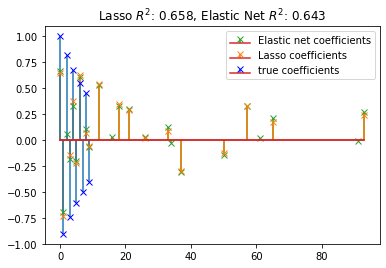

In [1]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

# #############################################################################
# Generate some sparse data to play with
np.random.seed(42)

n_samples, n_features = 50, 100
X = np.random.randn(n_samples, n_features)

# Decreasing coef w. alternated signs for visualization
idx = np.arange(n_features)
coef = (-1) ** idx * np.exp(-idx / 10)
coef[10:] = 0  # sparsify coef  只有10个特征是有用的
y = np.dot(X, coef)

# Add noise
y += 0.01 * np.random.normal(size=n_samples)

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:n_samples // 2], y[:n_samples // 2]
X_test, y_test = X[n_samples // 2:], y[n_samples // 2:]

# #############################################################################
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

# #############################################################################
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)  # 正则项系数, 凸组合系数

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

m, s, _ = plt.stem(np.where(enet.coef_)[0], enet.coef_[enet.coef_ != 0],
                   markerfmt='x', label='Elastic net coefficients',
                   use_line_collection=True)
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(np.where(lasso.coef_)[0], lasso.coef_[lasso.coef_ != 0],
                   markerfmt='x', label='Lasso coefficients',
                   use_line_collection=True)
plt.setp([m, s], color='#ff7f0e')
plt.stem(np.where(coef)[0], coef[coef != 0], label='true coefficients',
         markerfmt='bx', use_line_collection=True)

plt.legend(loc='best')
plt.title("Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f"
          % (r2_score_lasso, r2_score_enet))
plt.show()